 First of all, install requirements :

In [ ]:
%pip install pymc3
%pip install seaborn
%pip install prophet 

Add General Libraries 

In [1]:
import numpy as np
import pandas as pd
import seaborn as snn
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [2]:
import arviz as az
import pymc3 as pm
import theano.tensor as tt
from prophet import Prophet

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/dev01/TTS/proj_all/PYMC3/.venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def delayed_adstock(x, theta, alpha,L):
    w = tt.as_tensor_variable([tt.power(alpha,tt.power(i-theta,2)) for i in range(L)])
    xx = tt.stack([tt.concatenate([tt.zeros(i), x[:x.shape[0] -i]]) for i in range(L)])
    return tt.dot(w/tt.sum(w), xx)

def mul_coef(x,b):
    return b * x

Read Test Data :

In [4]:
media_channels = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]
control_variables = ["trend", "season"]
channels_sum_control = ["spend_channel_1", "spend_channel_2", "spend_channel_3","spend_channel_4",
                                    "spend_channel_5", "spend_channel_6", "spend_channel_7", "trend", "season"]
target = "revenue"
url = 'MMM_test_data.csv'

data = pd.read_csv(url,parse_dates=['start_of_week'])
y = data[target].values

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
revenue,104.0,136490.190673,50810.253012,63207.09,101675.6850,128790.460,157707.2800,418186.38
spend_channel_1,104.0,1245.604808,1388.384632,0.00,334.2750,856.870,1658.0325,8513.83
spend_channel_2,104.0,343.640962,332.988218,4.37,120.4700,202.020,553.0750,1605.85
spend_channel_3,104.0,19507.177981,8714.759886,5938.13,13879.0000,17929.450,22252.2625,49689.38
spend_channel_4,104.0,6915.136731,3123.172035,3602.20,5113.9375,6194.400,7470.5575,22629.69
spend_channel_5,104.0,8575.611442,6956.787524,747.46,2902.0325,6879.270,14367.5825,33009.65
spend_channel_6,104.0,5063.699038,6689.472660,0.00,0.0000,2423.095,8701.9600,33692.83
spend_channel_7,104.0,27701.367404,12176.293684,9391.21,19797.7100,24248.640,33852.6525,77488.42


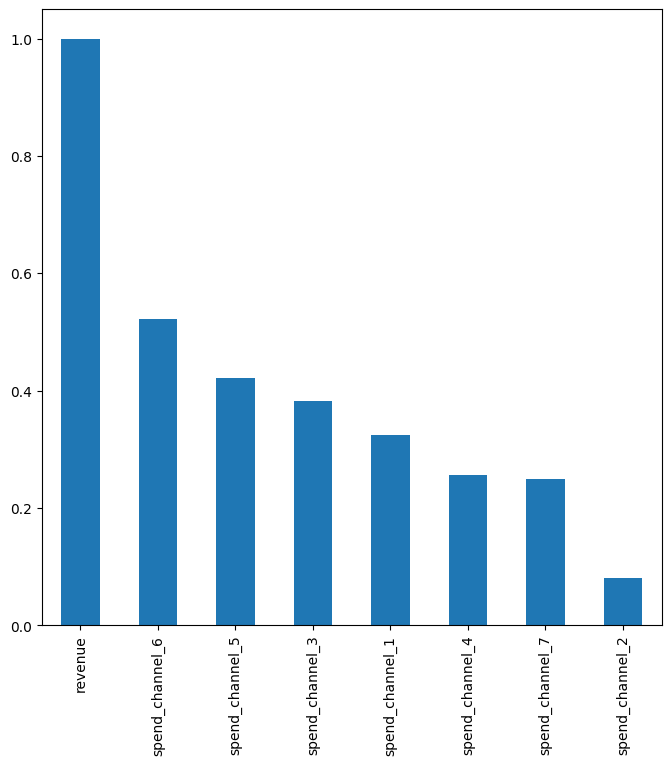

In [6]:
plt.figure(figsize=(8,8))
bars = data.corr()['revenue'].sort_values(ascending=False).plot(kind='bar')

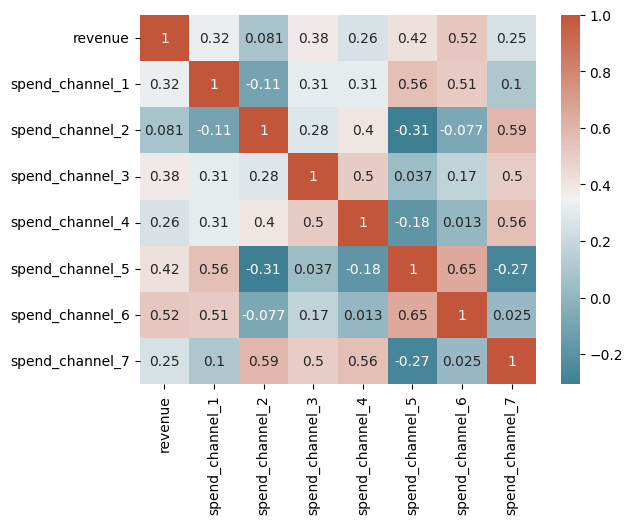

In [7]:
heatmap = snn.heatmap(data.corr(), xticklabels = data.corr().columns, yticklabels = data.corr().columns, annot = True, cmap = snn.diverging_palette(220, 20, as_cmap=True))

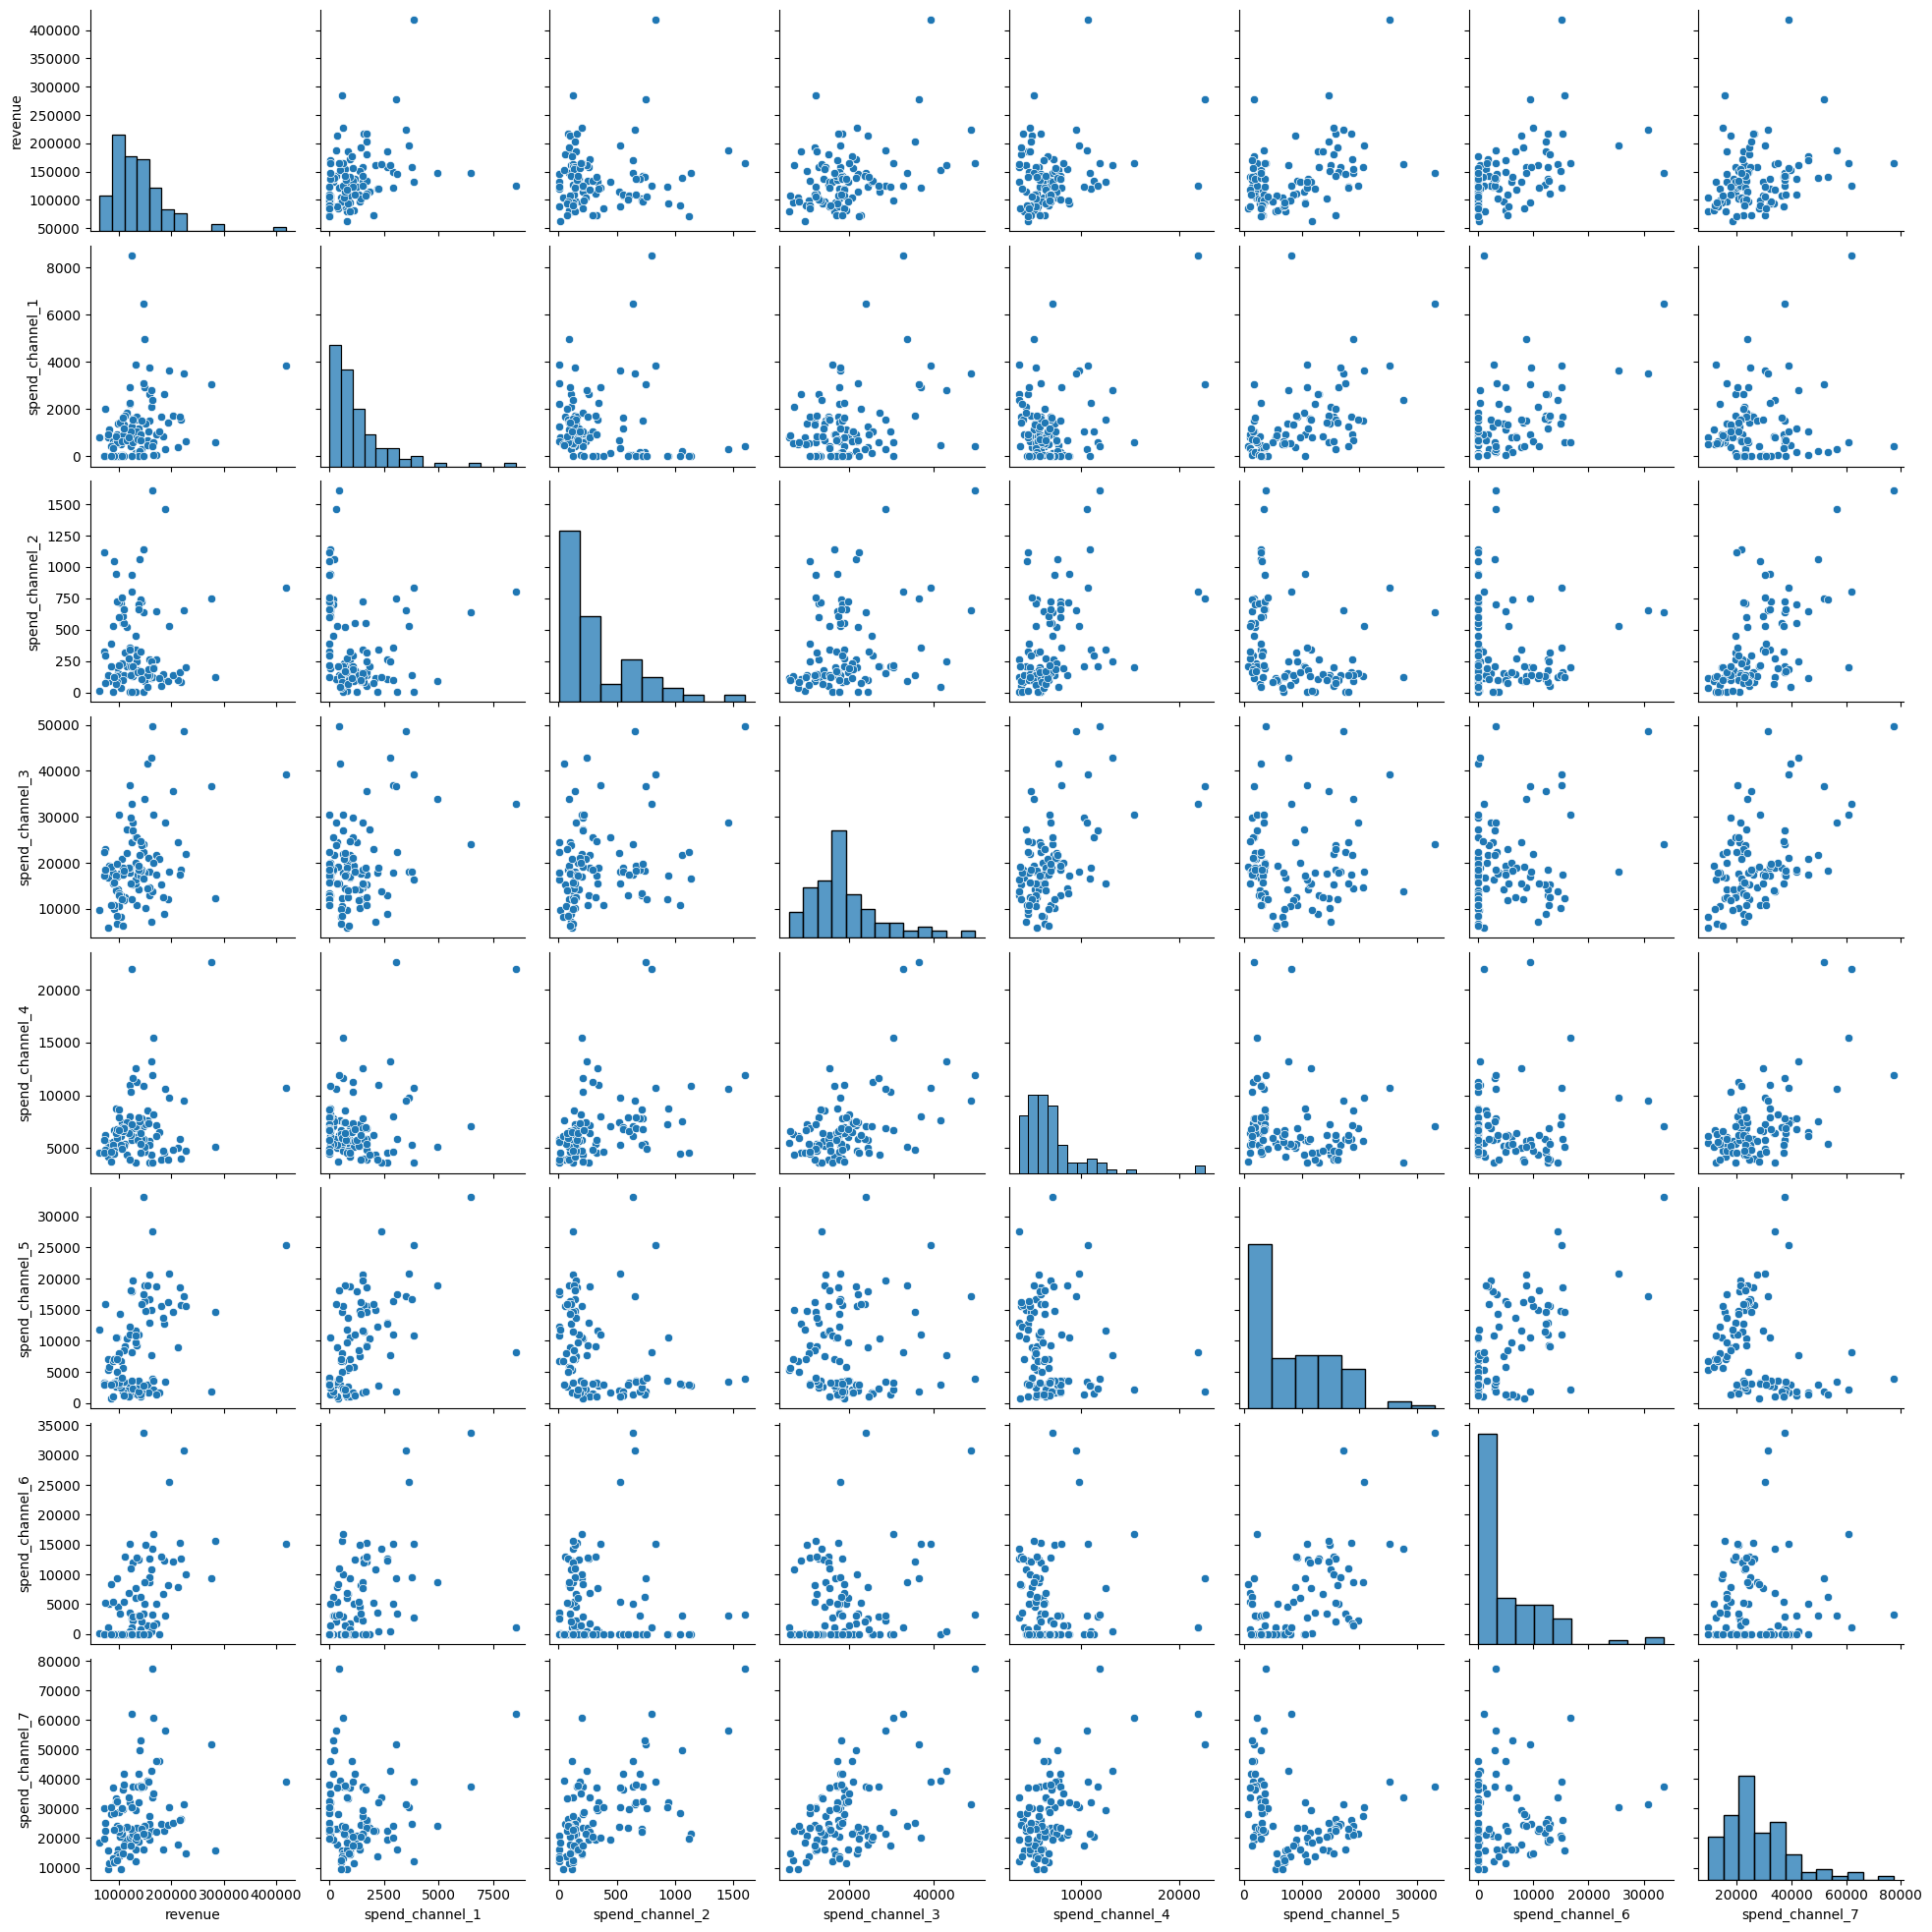

In [8]:
snn.pairplot(data)

12:13:55 - cmdstanpy - INFO - Chain [1] start processing
12:13:55 - cmdstanpy - INFO - Chain [1] done processing


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,trend,season
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,190541.187624,320.817740
1,2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,183376.317527,5564.671751
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,178599.737463,-3155.399741
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,178360.908460,-2606.394673
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,173584.328480,-13290.886146


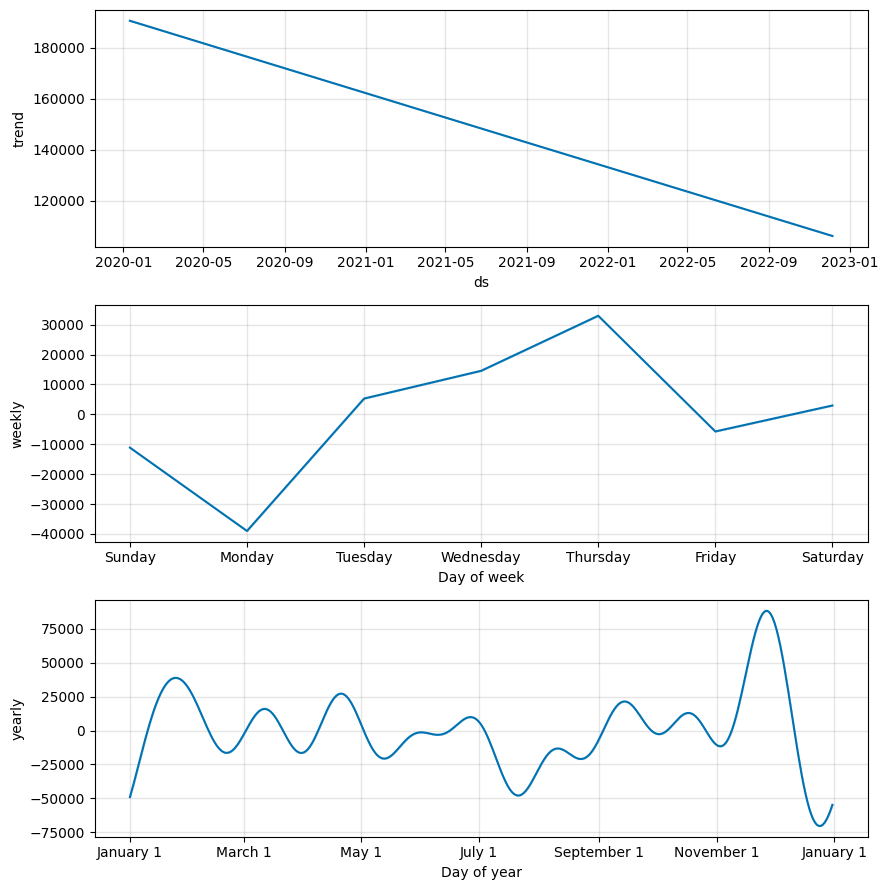

In [9]:
# trend and Year
prophet_data = data.rename(columns = {'revenue': 'y', 'start_of_week': 'ds'})
prophet = Prophet(yearly_seasonality=True)
prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])
prophet.plot_components(prophet_predict)

data["trend"] = prophet_predict["trend"]
data["season"] = prophet_predict["yearly"]

data.head()

In [10]:
for feature in channels_sum_control:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data[feature] = transformed

dependent_transformation = None
original = data[target].values
data[target] = original / 100_000

data.head()

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,trend,season
0,2020-08-30,1.579068,0.308378,0.161313,0.160361,0.000390,0.378394,0.375721,0.146681,1.000000,0.444170
1,2020-06-09,1.864257,0.309380,0.065121,0.064504,0.050369,0.371960,0.366196,0.192111,0.915017,0.477513
2,2020-09-13,1.616074,0.245140,0.066158,0.027823,0.039982,0.442250,0.320874,0.193912,0.858362,0.422066
3,2020-09-20,1.800891,0.198583,0.030235,0.211356,0.014779,0.457934,0.382581,0.225230,0.855529,0.425557
4,2020-09-27,2.177940,0.181740,0.047575,0.287670,0.023171,0.466375,0.375230,0.251468,0.798874,0.357618


In [11]:
with pm.Model() as m:
    alpha = pm.Beta('alpha', 3 , 3, shape = 7)
    theta = pm.Uniform('theta', 0 , 1, shape = 7)
    beta  = pm.HalfNormal('beta', 1, shape=7)
    tau    = pm.HalfNormal('intercept', 5)
    control  = pm.Normal('control', 0 , 1, shape =2)
    noise = pm.InverseGamma('noise',   0.05,  0.005)
    
    computations = []
    for idx, col in enumerate(media_channels):
        comp = mul_coef(x=delayed_adstock(x=data[col].values, 
                                                alpha = alpha[idx],
                                                theta= theta[idx],
                                                L=1),
                        b=beta[idx])
        computations.append(comp)

    for idx, ctrl_var in enumerate(control_variables):
        x = data[ctrl_var].values
        control_x = control[idx] * x
        computations.append(control_x)


    y_hat = pm.Normal('y_hat', mu= tau + sum(computations),
                sigma=noise, 
                observed=y)
    trace = pm.sample(init='adapt_diag')
    trace_summary = az.summary(trace)


/home/dev01/TTS/proj_all/PYMC3/.venv/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, control, intercept, beta, theta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/dev01/TTS/proj_all/PYMC3/.venv/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


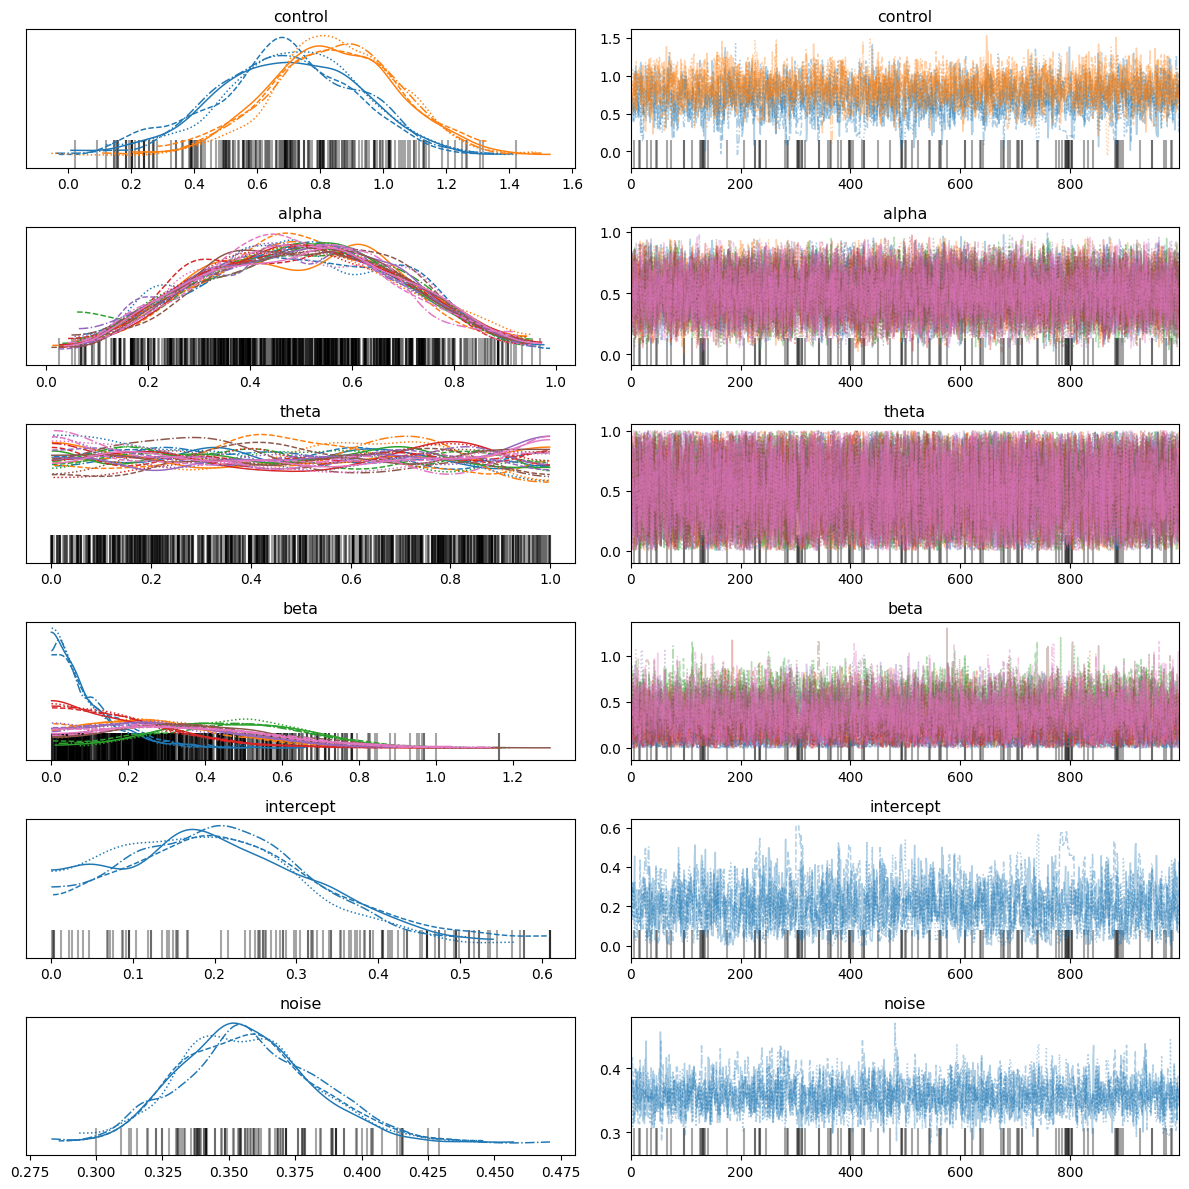

In [12]:
az.plot_trace(trace)
plt.tight_layout()

In [13]:
trace_summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
control[0],0.696,0.224,0.256,1.100,0.007,0.005,1092.0,572.0,1.00
control[1],0.844,0.204,0.452,1.220,0.005,0.003,1896.0,1353.0,1.00
alpha[0],0.499,0.191,0.156,0.833,0.004,0.003,2249.0,1821.0,1.00
alpha[1],0.502,0.189,0.169,0.866,0.004,0.003,2356.0,1834.0,1.00
alpha[2],0.494,0.190,0.134,0.826,0.004,0.003,1887.0,951.0,1.00
alpha[3],0.495,0.188,0.162,0.832,0.004,0.003,2055.0,1514.0,1.00
alpha[4],0.496,0.190,0.152,0.840,0.004,0.003,1973.0,1196.0,1.00
alpha[5],0.505,0.189,0.145,0.828,0.004,0.003,2763.0,1787.0,1.00
alpha[6],0.495,0.187,0.157,0.828,0.004,0.003,2423.0,1715.0,1.00
theta[0],0.488,0.285,0.024,0.951,0.006,0.004,2203.0,2177.0,1.00


Got error No model on context stack. trying to find log_likelihood in translation.
/home/dev01/TTS/proj_all/PYMC3/.venv/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


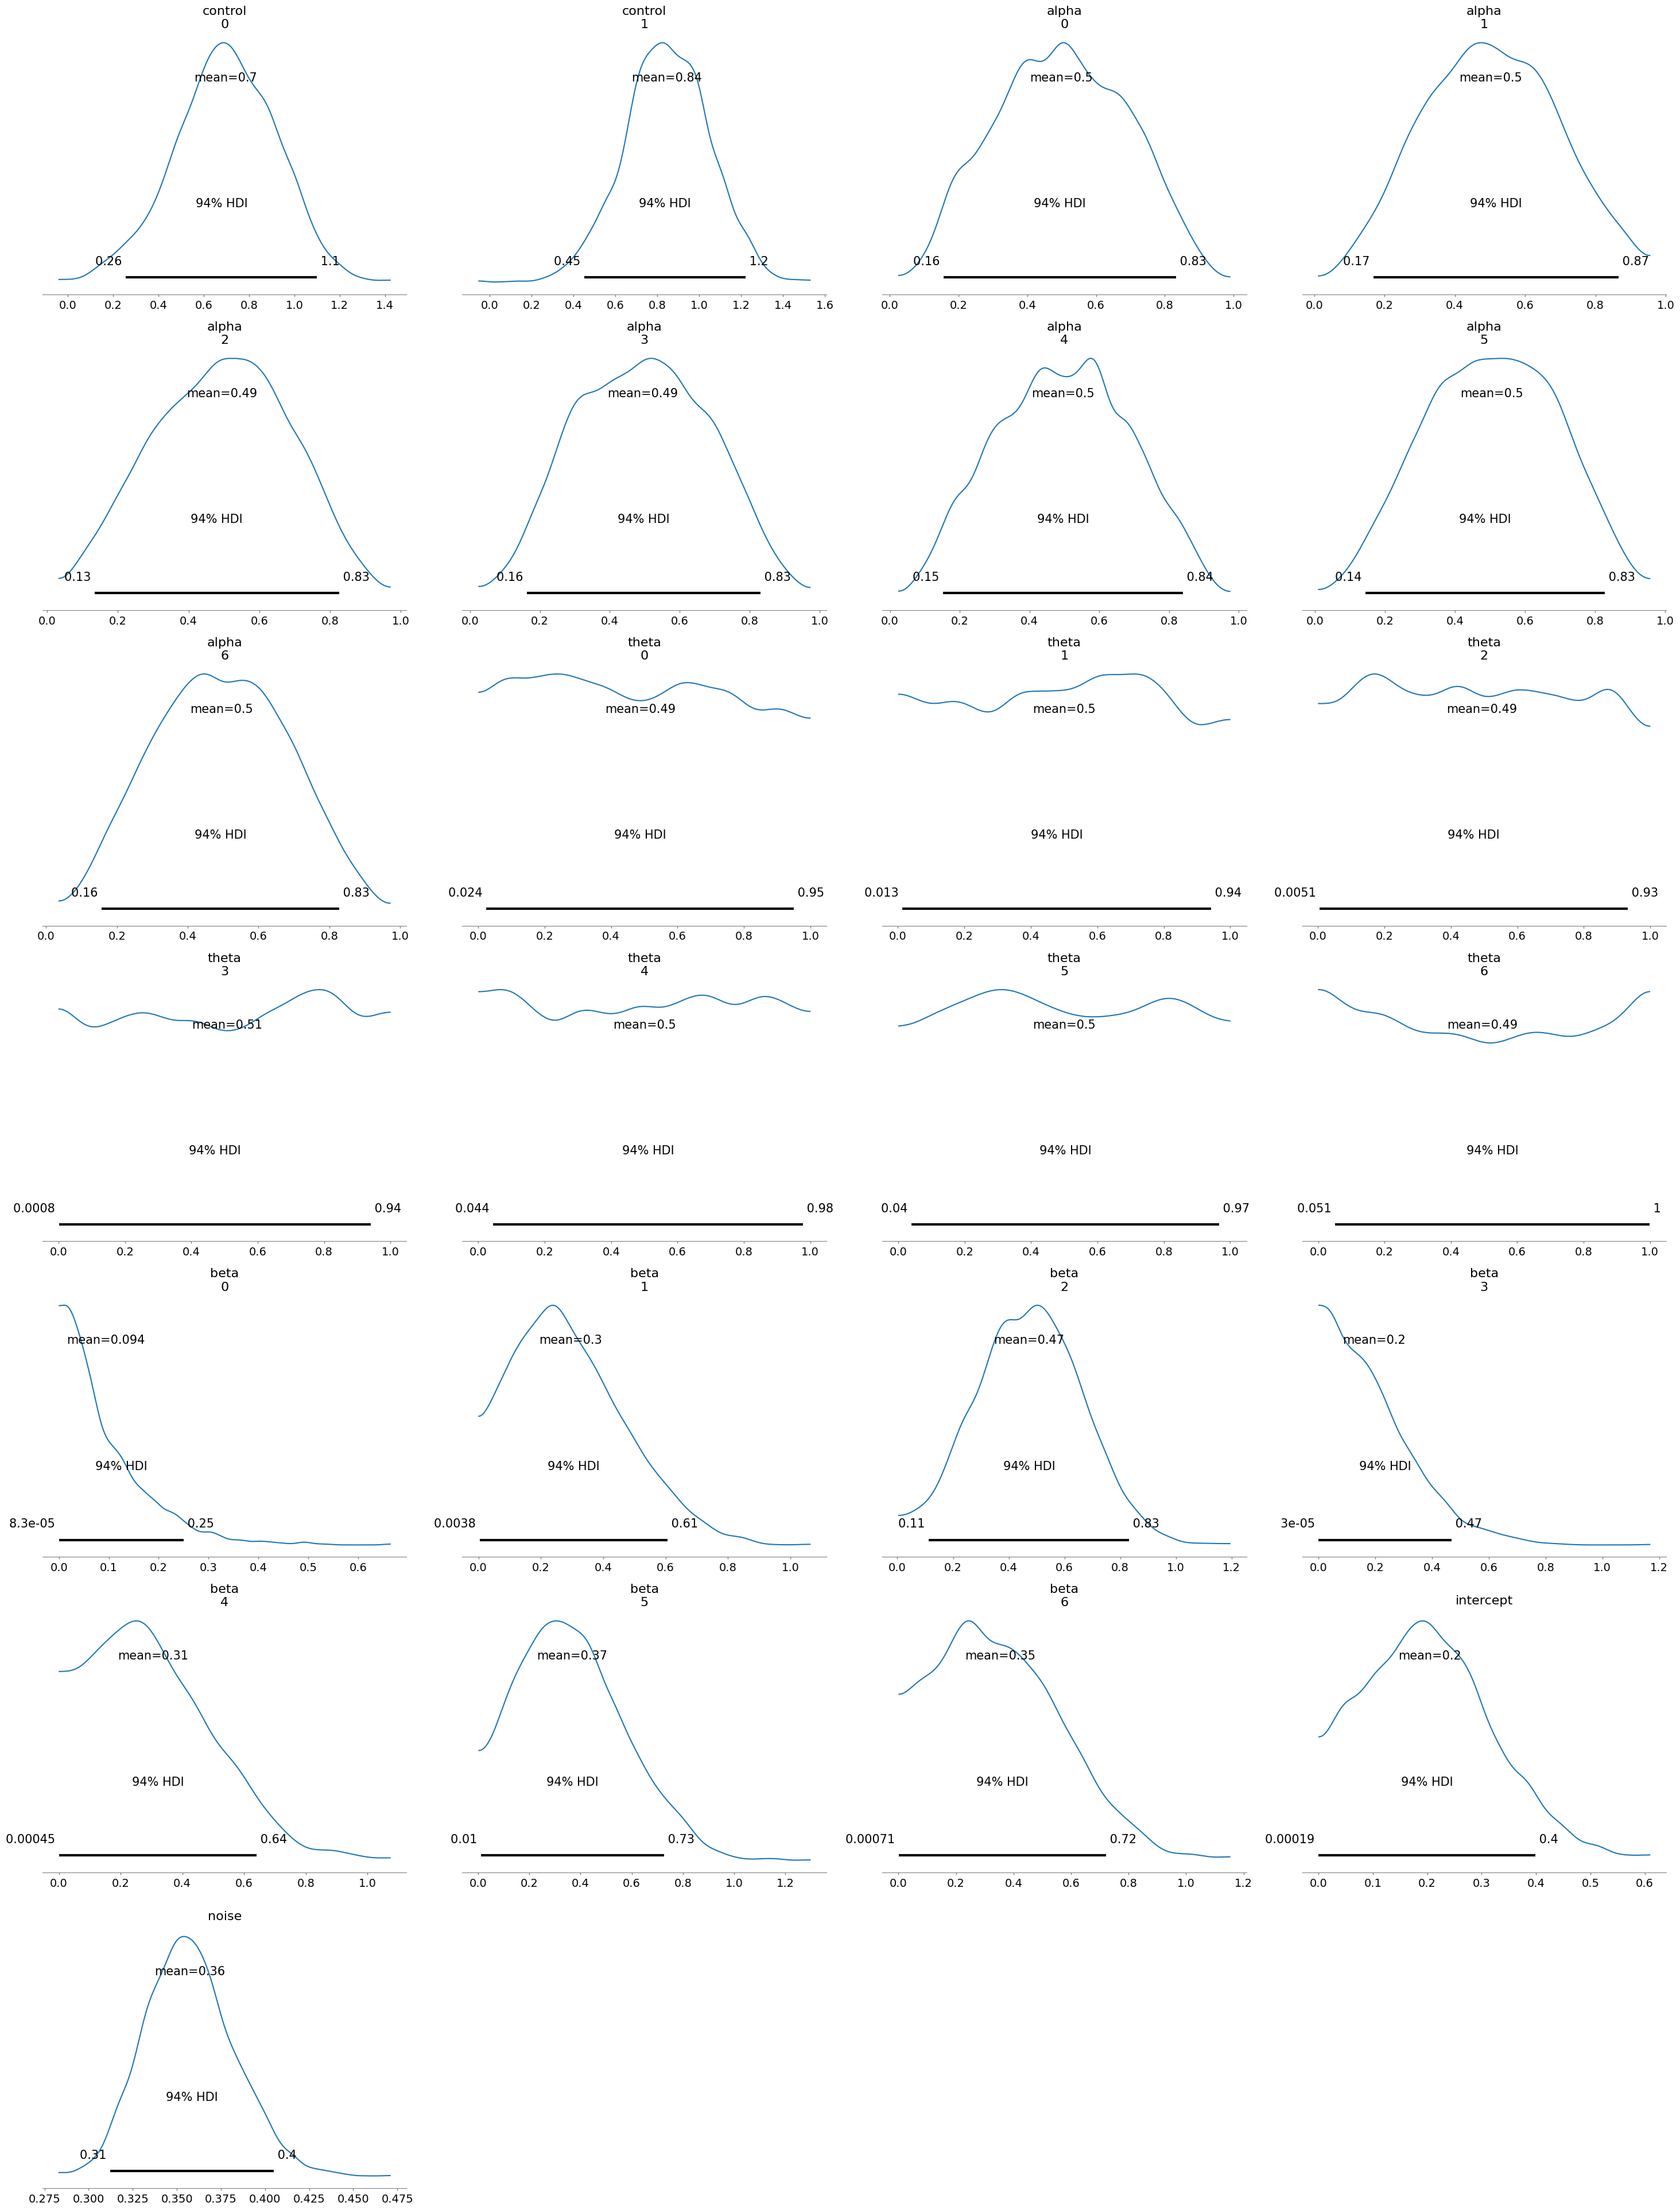

In [14]:
az.plot_posterior(trace)
plt.tight_layout()

Compute ROAS

In [ ]:
# simulate ROAS 
b_sample= []
t_sample = []
a_sample = []
ctrl_sample = []
y_hat_m = []

L = 1
media_number = 7
all_medias_roas = [[]]*media_number

for i in range(10):
    burnin=5
    s = np.random.randint(1,1000-burnin)
    intercept = trace['intercept'][s]

    for i in range(media_number):
        b_sample.append(trace['beta'][:,i][burnin:][s])
        a_sample.append(trace['alpha'][:,i][burnin:][s])
        t_sample.append(trace['theta'][:,i][burnin:][s])

    for i in range(2):
        ctrl_sample.append(trace['control'][:,i][burnin:][s])

    computations = []
    for idx, col in enumerate(media_channels):
        comp = mul_coef(x=delayed_adstock(x=data[col].values, 
                                                alpha = a_sample[idx],
                                                theta= t_sample[idx],
                                                L=1),
                        b=b_sample[idx])
        computations.append(comp)

    for idx, ctrl_var in enumerate(control_variables):
        x = data[ctrl_var].values
        control_x = ctrl_sample[idx] * x
        computations.append(control_x)


    y_hat = (intercept + sum(computations))

    for indx in range(7):
        acc = []
        for noindx in range(media_number):
            if noindx!= indx:
                acc.append(computations[noindx])
        y_hat_m.append(intercept + sum(computations[media_number],computations[8]) + sum(acc))
        acc.clear()

    sum_medias=data[media_channels][L:104-L].sum()
    for idx, col in enumerate(media_channels):
        all_medias_roas[idx].append((y_hat-y_hat_m[idx]).sum()/ sum_medias[idx])

    y_hat_m.clear()
    b_sample.clear()
    a_sample.clear()
    t_sample.clear()
    ctrl_sample.clear()
wss = tt.as_tensor_variable(all_medias_roas[0])
ali =wss.eval()
g = snn.displot(x=wss.eval())
plt.axvline(x=np.mean(wss.eval()), color="C0", linestyle="--",)
